In [29]:
#libraries used in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas_datareader as pdr
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM

# Extracting data from the last decade

In [32]:
#company = input("Name of company")
df = pdr.DataReader('GOOGL',data_source='yahoo',start='2010-01-01',end='2020-01-01')
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,315.070068,312.432434,313.788788,313.688690,3908400.0,313.688690
2010-01-05,314.234222,311.081085,313.903900,312.307312,6003300.0,312.307312
2010-01-06,313.243256,303.483490,313.243256,304.434448,7949400.0,304.434448
2010-01-07,305.305298,296.621613,305.005005,297.347351,12815700.0,297.347351
2010-01-08,301.926941,294.849854,296.296295,301.311310,9439100.0,301.311310


# Visualizing data from last decade

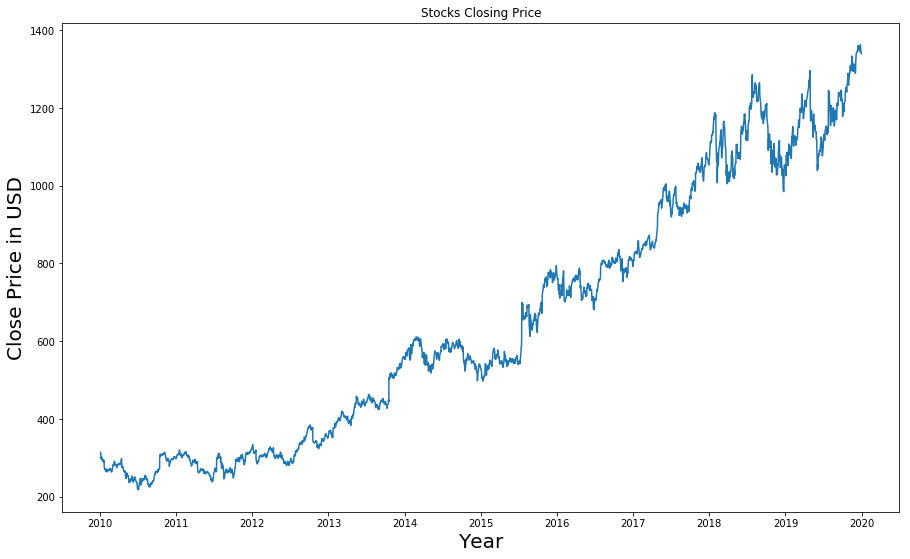

In [33]:
#See the closing price on graph
plt.figure(figsize=(15,9))
plt.xlabel('Year',fontsize=20)
plt.ylabel('Close Price in USD',fontsize=20)
plt.title('Stocks Closing Price')
plt.plot(df['Close'])

# Preprocessing the data

In [36]:
close_df = df.filter(['Close'])
close = close_df.values

In [37]:
scaler = MinMaxScaler()
rescaled_weights = scaler.fit_transform(close)
rescaled_weights

array([[0.08340679],
       [0.08219952],
       [0.07531895],
       ...,
       [0.99315693],
       [0.98010865],
       [0.97982903]])

# Splitting the data in 80/20 for training

In [39]:
train_len = int(len(close) * 0.8) + 1
train_data = rescaled_weights[0:train_len , : ]
test_data = rescaled_weights[train_len-100: , : ]
#splitting train data
x_train = []
y_train = []
for i in range(100,len(train_data)):
    x_train.append(train_data[i-100:i,0])
    y_train.append(train_data[i,0])
#convert to numpy
x_train,y_train = np.array(x_train),np.array(y_train)

In [40]:
#splitting test data
x_test = []
y_test = close[train_len: , : ]
for i in range(100,len(test_data)):
    x_test.append(test_data[i-100:i,0])
#convert to numpy
x_test = np.array(x_test)

In [41]:
x_train.shape

(1913, 100)

In [42]:
x_test.shape

(503, 100)

In [43]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train

array([[[0.08340679],
        [0.08219952],
        [0.07531895],
        ...,
        [0.01797349],
        [0.01793412],
        [0.01723426]],

       [[0.08219952],
        [0.07531895],
        [0.0691251 ],
        ...,
        [0.01793412],
        [0.01723426],
        [0.02379115]],

       [[0.07531895],
        [0.0691251 ],
        [0.07258945],
        ...,
        [0.01723426],
        [0.02379115],
        [0.02167842]],

       ...,

       [[0.63583822],
        [0.63580329],
        [0.63443991],
        ...,
        [0.7451357 ],
        [0.74339653],
        [0.7407659 ]],

       [[0.63580329],
        [0.63443991],
        [0.63084795],
        ...,
        [0.74339653],
        [0.7407659 ],
        [0.735828  ]],

       [[0.63443991],
        [0.63084795],
        [0.61643635],
        ...,
        [0.7407659 ],
        [0.735828  ],
        [0.73211367]]])

# Making the LSTM network model

In [44]:
model = Sequential()
model.add(LSTM(units=50,
          return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [45]:
#Compiling LSTM
model.compile(optimizer='adam',loss='mean_squared_error')

# Train the model

In [46]:
model.fit(x_train,y_train,batch_size=1,epochs=1)

1913/1913 [==============================] - 124s 65ms/step - loss: 9.5158e-04


# Test the model

In [47]:
#reshape test data
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [48]:
#predicting from the model
predict_model = model.predict(x_test)
predict_model = scaler.inverse_transform(predict_model)

In [49]:
#Check root mean squared error
rmsq = np.sqrt(np.mean((predict_model-y_test)**2))
rmsq

36.35210164316765

# Visualizing the data

C:\Users\Prabhnoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


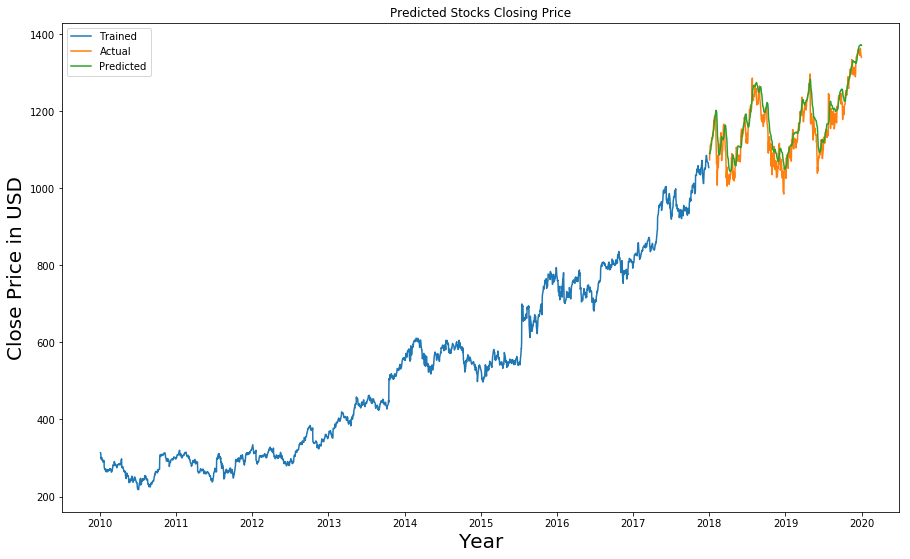

In [62]:
prev = close_df[0:train_len]
predict = close_df[train_len:]
predict['Predicted'] = predict_model

plt.figure(figsize=(15,9))
plt.xlabel('Year',fontsize=20)
plt.ylabel('Close Price in USD',fontsize=20)
plt.title('Predicted Stocks Closing Price')
plt.plot(prev['Close'])
plt.plot(predict[['Close','Predicted']])
plt.legend(['Trained','Actual','Predicted'])

In [52]:
predict.head(5)

,Close,Predicted
Date,,
2018-01-02,1073.209961,1089.570557
2018-01-03,1091.520020,1089.116943
2018-01-04,1095.760010,1091.171631
2018-01-05,1110.290039,1094.768799
2018-01-08,1114.209961,1100.319580


# Predicting the data for today's stock and verifying

In [53]:
df_verify = pdr.DataReader('GOOGL',data_source='yahoo',start='2010-01-01',end='2020-06-23')

In [57]:
value_verify = df_verify.filter(['Close'])[-100:].values
value_verify = scaler.fit_transform(value_verify)

In [58]:
x_test = [value_verify]
x_test = np.array(x_test)

In [59]:
#reshaping to 3D
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
price_today = model.predict(x_test)
price_today = scaler.inverse_transform(price_today)
price_today

array([[1448.7203]], dtype=float32)

In [63]:
df_verify = pdr.DataReader('GOOGL',data_source='yahoo',start='2020-06-24',end='2020-06-24')
df_verify['Close']

Date
2020-06-24    1432.699951
Name: Close, dtype: float64

<BarContainer object of 1 artists>

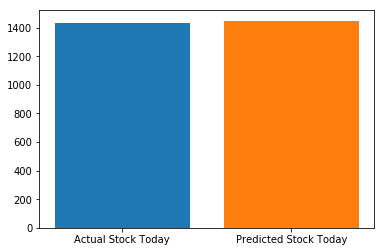

In [64]:
plt.bar("Actual Stock Today",df_verify['Close'])
plt.bar("Predicted Stock Today",price_today[0])